## Made this notebook to do a full run with 100hrs at 0.1 time step.

Collecting P, C, R, S, F2, F3, A every half-hour. Collecting S every 0.5min.

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib
import numpy as np
import matplotlib.cm as cm
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimize
from scipy import integrate

In [2]:
#Define parameters from paper
alpha_ptc = 0.024
gamma_p = 0.006
gamma_c = 0.1067
K_h = 1.8124
k_off = 0.9157
k_on = K_h * k_off
K_p = 0.01
n_p = 1.3007
alpha_f = 0.7610
gamma_f = 0.002
alpha_a = 1.9996
alpha_R2 = 0.00326
alpha_R3 = 0.0315
gamma_a = 0.02
gamma_R = 0.002
K_gli = 0.1501
alpha_GBS = 0.0022
alpha_GBS0 = 1.384e-4
D_diff = 52.3942
alpha_HH = 0.4898
gamma_H = 7.644e-6
beta = 16
m = 2.5595
beta_fl = 2.3797
t_dr = 30

In [3]:
def create_d_matrix(n):
    h = 1/(n-1)
    D = -2*np.identity(n) 
    for i in range(n-1):
        D[i+1, i] = 1
        D[i, i+1] = 1       
    D[n-1] = 0
    D[0,1] = 2    
    return D

In [4]:
def AF(t):
    if t < t_dr:
        return alpha_f
    elif t >= t_dr and t < 2.5*t_dr:
        return alpha_f*(2.5*t_dr - t)/(1.5*t_dr)
    else:
        return 0
        
def update_H(H, P, C, t, D):
    n = len(H)
    h = 1/(n-1)
    alpha = (D_diff*t)/(h**2)
    M = H + (k_off*C)
    M[0] += (alpha_HH/D_diff)*2*h*alpha
    
    Differentiation_Matrix = D
    matrix_HP = np.matmul(k_off*P, np.identity(n))
    matrix_gamma = gamma_H * np.identity(n)
    
    A = np.identity(n) - ((alpha*Differentiation_Matrix) - matrix_HP - matrix_gamma)
    future_H = np.linalg.solve(A, M)
    
    future_H[future_H < 0] = 0
    return future_H

def phi_AR(A,R):
    num = A**2 + K_gli*A
    den = A**2 + 2*K_gli*A + 2*K_gli*R + 2*A*R + R**2 + K_gli**2
    return num/den


def update_P(H, A, P, R, C, t):
    phi = phi_AR(A,R)
    n = len(H)
    delta = ((alpha_ptc)*np.ones(n)) + ((alpha_ptc)*beta*phi) - (gamma_p*P) - (k_on*H*P) + (k_off*C)
    future_P = P + delta*t
    future_P[future_P < 0] = 0
    return future_P
    
def update_C(H, P, C, t):
    n = len(H)
    delta = (k_on*H*P) - (k_off*C) - (gamma_c*C)
    future_C = C + delta*t
    future_C[future_C < 0] = 0      
    return future_C

def update_F2(A,R,P,F2,t, elapsed_time):
    af = AF(elapsed_time)
    phi = phi_AR(A,R)
    g1 = af*(1+beta_fl*phi)
    g2 = alpha_a*((K_p**n_p)/((K_p**n_p)+(P**n_p))) + alpha_R2 + gamma_f
    delta = (g1 - g2*F2)
    future_F2 = F2 + delta*t
    future_F2[future_F2 < 0] = 0
    return future_F2

def update_F3(P,F3,t, elapsed_time):
    af = AF(elapsed_time)
    delta = af - (alpha_a*((K_p**n_p)/((K_p**n_p)+(P**n_p))) + alpha_R3 + gamma_f)*F3
    future_F3 = F3 + delta*t
    future_F3[future_F3 < 0] = 0
    return future_F3   

def update_R(F2, F3, R, t):
    delta = alpha_R2*F2 + alpha_R3*F3 - gamma_R*R
    future_R = R + delta*t
    future_R[future_R < 0] = 0
    return future_R
    
def update_A(P, F2, F3, A, t):
    delta = alpha_a*((K_p**n_p)/((K_p**n_p)+(P**n_p)))*(F2+F3) - gamma_a*A
    future_A = A + delta*t
    future_A[future_A < 0] = 0
    return future_A

def update_S(R, A, S, t):
    phi = phi_AR(A,R)
    n = len(R)
    delta = (alpha_GBS0*np.ones(n)) + (alpha_GBS*phi) #*1000
    future_S = S + delta*t
    future_S[future_S < 0] = 0
    return future_S

In [5]:
def integrate_solution(final_time, time_step, n):
    H = np.zeros(n)
    C = np.zeros(n)
    S = np.zeros(n)
    F2 = 125*np.ones(n)
    F3 = 22*np.ones(n)
    A = 6*np.ones(n)
    P = 4*np.ones(n)
    R = 550*np.ones(n)
    time = 0; #start time
    D = create_d_matrix(n); #create differentiation matrix for diffusion
    min_to_collect_at = 30;
    hrs = int( np.floor( final_time / min_to_collect_at)); #number of hours we will simulate over
    
    #make arrays to hold the values of each protein at each grid point at each hour
    H_vals = np.zeros((hrs+1,n));
    H_vals[0] = H; #initialize at t=0
    C_vals = np.zeros((hrs+1,n));
    C_vals[0] = C; #initialize at t=0
    S_vals = []; #need this to be a list since we are appending at every half-min
    S_vals.append(S); #initialize at t=0
    P_vals = np.zeros((hrs+1,n));
    P_vals[0] = P; #initialize at t=0
    R_vals = np.zeros((hrs+1,n));
    R_vals[0] = R; #initialize at t=0
    F2_vals = np.zeros((hrs+1,n));
    F2_vals[0] = F2; #initialize at t=0
    F3_vals = np.zeros((hrs+1,n));
    F3_vals[0] = F3; #initialize at t=0
    A_vals = np.zeros((hrs+1,n));
    A_vals[0] = A; #initialize at t=0
    
    #need plus one because there is some rounding error in the addition for the time step
    steps_each_hr = min_to_collect_at / time_step + 1; 
    print("Number of steps to take each hour: ", steps_each_hr);
    steps_each_half_min = 0.5 / time_step; #should be taking sample of S 
    print("Number of steps to take to reach 0.5min : ", steps_each_half_min);
    steps = 0;
    
    while time<final_time:
        #calculate the updates for each protein
        P_upd = update_P(H, A, P, R, C, time_step);
        C_upd = update_C(H, P, C, time_step);
        F2_upd = update_F2(A,R,P,F2,time_step, time/60);
        F3_upd = update_F3(P,F3,time_step, time/60);
        R_upd = update_R(F2, F3, R, time_step);
        A_upd = update_A(P, F2, F3, A, time_step);
        S_upd = update_S(R, A, S, time_step);
        
        P = P_upd.copy();
        C = C_upd.copy();
        
        H_upd = update_H(H, P, C, time_step, D);
        #reassign each protein to new concentrations
        H = H_upd.copy();
        F2 = F2_upd.copy();
        F3 = F3_upd.copy();
        R = R_upd.copy();
        A = A_upd.copy();
        S = S_upd.copy();
        
        time += time_step #increment total time
        steps +=1;
        if steps % steps_each_half_min == 0:
            S_vals.append(S);
        if steps == steps_each_hr : #we've reached an hour
            #store protein concentrations at each grid point for this hour
            index = int(time / min_to_collect_at);
            print("Index to insert at:", index, " at time ", time);
            H_vals[index] = H;
            P_vals[index] = P;
            C_vals[index] = C;
            F2_vals[index] = F2;
            F3_vals[index] = F3;
            R_vals[index] = R;
            A_vals[index] = A;
            steps = 0; #reinitialize steps
            
    #add results from last time step to matrices
    H_vals[-1] = H;
    P_vals[-1] = P;
    C_vals[-1] = C;
    F2_vals[-1] = F2;
    F3_vals[-1] = F3;
    R_vals[-1] = R;
    A_vals[-1] = A;
    S_vals.append(S);
        
        
    return H_vals, P_vals, C_vals, R_vals, S_vals, F2_vals, F3_vals, A_vals;

In [6]:
from time import clock

c = clock();
hrs_to_sim = 100;
time_step = 0.1;
H, P, C, R, S, F2, F3, A = integrate_solution(hrs_to_sim*60, time_step, 420);
stop = clock();

print("Time: {0} min".format( (stop-c)/60 ) );

Number of steps to take each hour:  301.0
Number of steps to take to reach 0.5min :  5.0
Index to insert at: 1  at time  30.100000000000158
Index to insert at: 2  at time  60.200000000000585
Index to insert at: 3  at time  90.29999999999914
Index to insert at: 4  at time  120.39999999999743
Index to insert at: 5  at time  150.49999999999574
Index to insert at: 6  at time  180.59999999999403
Index to insert at: 7  at time  210.69999999999231
Index to insert at: 8  at time  240.7999999999906
Index to insert at: 9  at time  270.8999999999931
Index to insert at: 10  at time  300.99999999999994
Index to insert at: 11  at time  331.1000000000068
Index to insert at: 12  at time  361.20000000001363
Index to insert at: 13  at time  391.3000000000205
Index to insert at: 14  at time  421.4000000000273
Index to insert at: 15  at time  451.50000000003416
Index to insert at: 16  at time  481.600000000041
Index to insert at: 17  at time  511.70000000004785
Index to insert at: 18  at time  541.8000000

Index to insert at: 158  at time  4755.79999999977
Index to insert at: 159  at time  4785.89999999988
Index to insert at: 160  at time  4815.999999999989
Index to insert at: 161  at time  4846.100000000099
Index to insert at: 162  at time  4876.200000000208
Index to insert at: 163  at time  4906.300000000318
Index to insert at: 164  at time  4936.400000000427
Index to insert at: 165  at time  4966.500000000537
Index to insert at: 166  at time  4996.600000000646
Index to insert at: 167  at time  5026.700000000756
Index to insert at: 168  at time  5056.800000000865
Index to insert at: 169  at time  5086.900000000975
Index to insert at: 170  at time  5117.000000001084
Index to insert at: 171  at time  5147.100000001194
Index to insert at: 172  at time  5177.200000001303
Index to insert at: 173  at time  5207.300000001413
Index to insert at: 174  at time  5237.400000001522
Index to insert at: 175  at time  5267.500000001632
Index to insert at: 176  at time  5297.600000001741
Index to inser

In [7]:
def normalize_S(S):
    normed_S = S.copy()
    normed_S = normed_S - np.min(normed_S)
    return normed_S

No handles with labels found to put in legend.


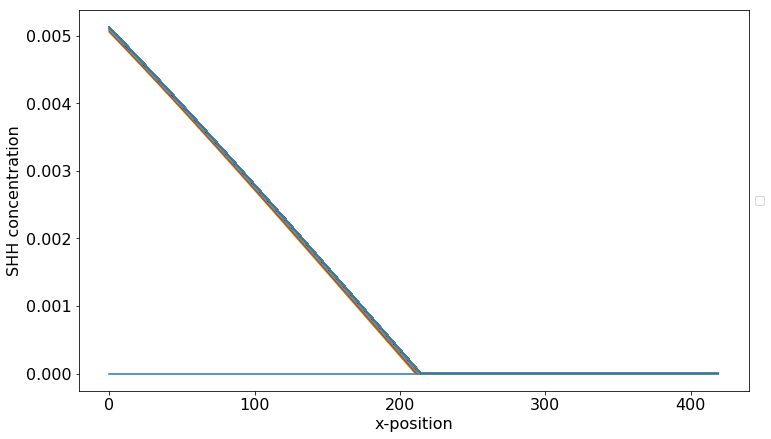

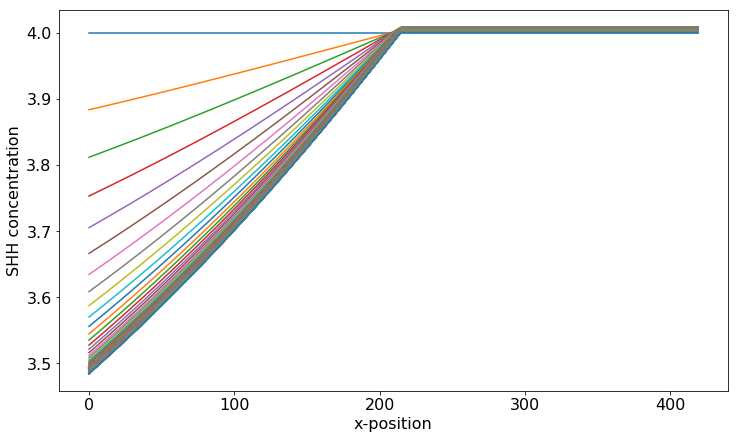

In [14]:
fig = plt.figure(figsize=(12,7));
ax = plt.subplot(1,1,1);
fontsize = 16
ax.tick_params(labelsize=fontsize);
ax.set_xlabel('x-position', fontsize=fontsize);
ax.set_ylabel('SHH concentration', fontsize=fontsize);

for i in range(len(H)):
    plt.plot(H[i])

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize= 12); 

plt.show();

fig = plt.figure(figsize=(12,7));
ax = plt.subplot(1,1,1);
fontsize = 16
ax.tick_params(labelsize=fontsize);
ax.set_xlabel('x-position', fontsize=fontsize);
ax.set_ylabel('SHH concentration', fontsize=fontsize);

for i in range(len(P)):
    plt.plot(P[i])

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize= 12); 

plt.show();

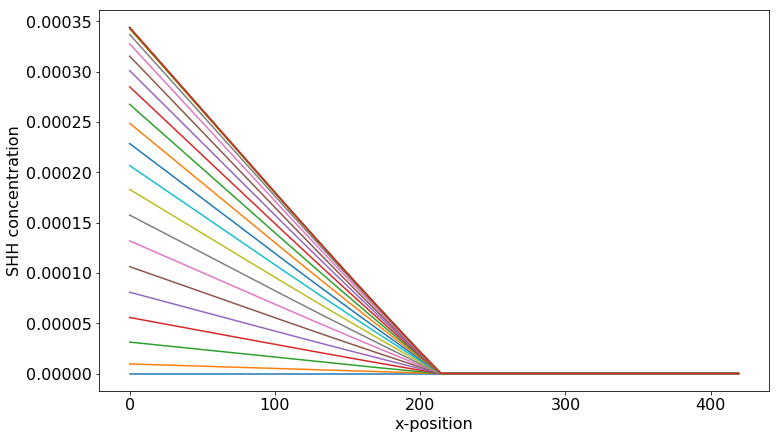

In [15]:
fig = plt.figure(figsize=(12,7));
ax = plt.subplot(1,1,1);
fontsize = 16
ax.tick_params(labelsize=fontsize);
ax.set_xlabel('x-position', fontsize=fontsize);
ax.set_ylabel('SHH concentration', fontsize=fontsize);

Ss = []
for i in range(len(S)):
    if i % 500 == 0:
        plt.plot(normalize_S(S[i]))
plt.show()

In [18]:
S_A = S[0:6000]
S_B = S[6000:]

In [22]:
len(S_A)

6000

In [26]:
prots = [H, P, C, R, S_A, S_B, F2, F3, A];
names = ["H", "P", "C", "R", "S_A", "S_B", "F2", "F3", "A"];

for i, p in enumerate(prots):
    print(names[i])
    file_name = "{0}_100hr_sim_final.csv".format(names[i]);
    np.savetxt(file_name, p, delimiter=",");

H
P
C
R
S_A
S_B
F2
F3
A
